# Automatic Translation

## Make workspace

In [3]:
# Make directories if they don't exist
!mkdir -p datasets
!mkdir -p plot
!mkdir -p model

## Imports

In [1]:
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras

2021-07-21 11:19:03.475765: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-07-21 11:19:03.475805: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Download datasets

Translation dataset used in original paper can be found [here](https://www.tensorflow.org/datasets/catalog/wmt14_translate)

In [4]:
# Download english language word list
if not os.path.exists('datasets/source_dictionary.txt'):
    !cd datasets && curl -o source_dictionary.txt https://raw.githubusercontent.com/dwyl/english-words/master/words_alpha.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4135k  100 4135k    0     0  3516k      0  0:00:01  0:00:01 --:--:-- 3516k


In [5]:
# Download french language word list
if not os.path.exists('datasets/target_dictionary.tsv'):
    !cd datasets && curl -O http://www.lexique.org/databases/Lexique383/Lexique383.zip
    !cd datasets && unzip Lexique383.zip
    !mv datasets/Lexique383.tsv datasets/target_dictionary.tsv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 25.9M  100 25.9M    0     0  1342k      0  0:00:19  0:00:19 --:--:-- 1058k
Archive:  Lexique383.zip
  inflating: Lexique383.rds          
  inflating: Lexique383.tsv          
  inflating: Lexique383.xlsb         
  inflating: Manuel_Lexique.3.pdf    
  inflating: README-Lexique.txt      
  inflating: RELEASE NOTES-Lexique.txt  
  inflating: make_rds.R              


In [6]:
# Download english-to-french translation dataset
if not os.path.exists('datasets/translation.txt'):
    !cd datasets && curl -O http://www.manythings.org/anki/fra-eng.zip
    !cd datasets && unzip fra-eng.zip fra.txt
    !mv datasets/fra.txt datasets/translation.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6300k  100 6300k    0     0  3575k      0  0:00:01  0:00:01 --:--:-- 3573k
Archive:  fra-eng.zip
  inflating: fra.txt                 


In [7]:
# Download english word embeddings
if not os.path.exists('datasets/glove.6B.100d.txt'):
    !cd datasets && curl -LO http://nlp.stanford.edu/data/glove.6B.zip
    !cd datasets && unzip glove.6B.zip glove.6B.100d.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   308    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0   345    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
100  822M  100  822M    0     0  4066k      0  0:03:27  0:03:27 --:--:-- 4971k 0     0  3277k      0  0:04:16  0:00:24  0:03:52 3313kk      0  0:03:13  0:01:36  0:01:37 5298k:03:31  0:03:02  0:00:29 4973k
Archive:  glove.6B.zip
  inflating: glove.6B.100d.txt       


## Settings

In [ ]:
# Use word lists from dictionary datasets or use words from translations
USE_WORD_LIST = False
# Use generators for loading data or load all at once
# (Generators require less RAM but can be slower to train on)
USE_DATA_GENERATORS = True

## Preprocessing

Sentences from the source and destination languages are converted to token sequences and padded to the same length. Source sentences are padded on the left and destination sentences on the right. Special tokens representing words not in dicionary (\<unk\>), start of sequence (\<sos\>) and end of sequence (\<eos\>) are added to the destination sentences. There are two generated destination sentences, one for decoder input (which has the start token appended), and one for decoder ouput (which has the end token appended). Source language sequences are reversed for better results.

In [8]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

### English word list

In [9]:
if USE_WORD_LIST:
    # Word list for source language
    source_words = []

    # Load source language word list and convert characters to lower
    with open('datasets/source_dictionary.txt') as f:
        source_words = f.read().lower().split('\n')
    print(source_words[:20])

    # Make source language tokenizer. UNK token is 1
    source_tokenizer = Tokenizer(num_words=len(source_words), oov_token=1)
    source_tokenizer.fit_on_texts(source_words)

['a', 'aa', 'aaa', 'aah', 'aahed', 'aahing', 'aahs', 'aal', 'aalii', 'aaliis', 'aals', 'aam', 'aani', 'aardvark', 'aardvarks', 'aardwolf', 'aardwolves', 'aargh', 'aaron', 'aaronic']


### French word list

In [10]:
if USE_WORD_LIST:
    # Word list for target language
    target_words = []

    # Load target language word list and convert characters to lower
    df = pd.read_csv('datasets/target_dictionary.tsv', sep='\t', keep_default_na=False)['ortho'].tolist()
    target_words = [w.lower() for w in df]
    print(target_words[:20])

    # Make target language tokenizer. UNK token is 1
    target_tokenizer = Tokenizer(num_words=len(target_words), oov_token=1)
    target_tokenizer.fit_on_texts(target_words)

['a', 'a', 'a', 'a capella', 'a cappella', 'a contrario', 'a fortiori', 'a giorno', 'a jeun', "a l'instar", 'a posteriori', 'a priori', 'a priori', 'aa', 'ab absurdo', 'ab initio', 'ab ovo', 'abaca', 'abaissa', 'abaissai']


### English-to-French translation dataset

In [11]:
SOS_TOKEN = '<sos>'
EOS_TOKEN = '<eos>'
UNK_TOKEN = '<unk>'

In [16]:
source_sentences = []
target_sentences_input = []
target_sentences_output = []

lines = []
with open('datasets/translation.txt') as f:
    lines = f.read().split('\n')

# Number of sentences to use
NUM_LINES = 20_000
count = 0
last_sentence = None
# Parse the source/target sentences and remove duplicates
for line in lines:
    source_sentence, target_sentence, _ = line.split('\t')
    if last_sentence is not None and last_sentence == source_sentence:
        continue
    last_sentence = source_sentence
    source_sentences.append(source_sentence)
    target_sentences_input.append(SOS_TOKEN + ' ' + target_sentence)
    target_sentences_output.append(target_sentence + ' ' + EOS_TOKEN)
    count += 1
    if count >= NUM_LINES:
        break

print(len(source_sentences))
print(source_sentences[:50])

20000
['Go.', 'Hi.', 'Run!', 'Run.', 'Who?', 'Wow!', 'Duck!', 'Fire!', 'Help!', 'Hide.', 'Jump!', 'Jump.', 'Stop!', 'Wait!', 'Wait.', 'Begin.', 'Go on.', 'Hello!', 'I see.', 'I try.', 'I won!', 'I won.', 'Oh no!', 'Relax.', 'Smile.', 'Sorry?', 'Attack!', 'Buy it.', 'Cheers!', 'Eat it.', 'Get up.', 'Go now.', 'Got it!', 'Got it?', 'Hop in.', 'Hug me.', 'I fell.', 'I fled.', 'I knit.', 'I know.', 'I left.', 'I lied.', 'I lost.', 'I paid.', 'I quit.', "I'm 19.", "I'm OK.", 'Listen.', 'No way!', 'Really?']


In [17]:
MAX_NUM_SOURCE_WORDS = 50_000
MAX_NUM_TARGET_WORDS = 50_000

In [18]:
if not USE_WORD_LIST:
    # Make source language tokenizer
    source_tokenizer = Tokenizer(num_words=MAX_NUM_SOURCE_WORDS)
    source_tokenizer.fit_on_texts(source_sentences)

    # Make destination language tokenizer
    # Don't filter '<' and '>' because they're used for SOS and EOS tokens
    target_tokenizer = Tokenizer(num_words=MAX_NUM_TARGET_WORDS, filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n')
    target_tokenizer.fit_on_texts(target_sentences_input + target_sentences_output)

In [ ]:
# Build word dictionaries
source_dict = source_tokenizer.word_index
NUM_SOURCE_WORDS = len(source_dict)+1

target_dict = target_tokenizer.word_index
NUM_TARGET_WORDS = len(target_dict)+1

In [19]:
print(len(source_dict))
print(len(target_dict))
print(source_dict)
print(target_dict)

4715
7738
{'i': 1, 'tom': 2, 'is': 3, 'a': 4, 'you': 5, 'it': 6, "i'm": 7, 'the': 8, 'he': 9, 'was': 10, 'this': 11, 'we': 12, 'that': 13, 'to': 14, "it's": 15, 'me': 16, 'my': 17, 'do': 18, 'not': 19, 'have': 20, 'are': 21, "we're": 22, 'your': 23, 'she': 24, "don't": 25, 'no': 26, 'can': 27, 'go': 28, "you're": 29, 'like': 30, 'they': 31, 'all': 32, 'what': 33, "that's": 34, 'in': 35, 'did': 36, "i'll": 37, 'here': 38, 'be': 39, 'need': 40, 'want': 41, 'on': 42, 'love': 43, 'him': 44, 'up': 45, 'one': 46, 'now': 47, 'how': 48, "he's": 49, 'get': 50, 'know': 51, "let's": 52, 'just': 53, 'has': 54, 'very': 55, "can't": 56, 'who': 57, 'come': 58, 'so': 59, 'will': 60, 'got': 61, 'too': 62, 'us': 63, "they're": 64, 'out': 65, 'am': 66, "tom's": 67, 'good': 68, 'of': 69, 'help': 70, 'there': 71, 'for': 72, 'at': 73, 'please': 74, 'see': 75, 'look': 76, 'stop': 77, 'hate': 78, "isn't": 79, 'had': 80, 'take': 81, 'her': 82, 'were': 83, 'work': 84, 'car': 85, 'his': 86, 'feel': 87, 'an': 88,

In [20]:
# Tokenize sentences to sequences
source_sequences = source_tokenizer.texts_to_sequences(source_sentences)
target_sequences_input = target_tokenizer.texts_to_sequences(target_sentences_input)
target_sequences_output = target_tokenizer.texts_to_sequences(target_sentences_output)

# Reverse source sequnces
for sequence in source_sequences:
    sequence.reverse()

max_source_len = max([len(sequence) for sequence in source_sequences])
max_target_len = max([len(sequence) for sequence in target_sequences_output])

encoder_input_sequences = pad_sequences(source_sequences, maxlen=max_source_len, padding='pre')
decoder_input_sequences = pad_sequences(target_sequences_input, maxlen=max_target_len, padding='post')
decoder_output_sequences = pad_sequences(target_sequences_output, maxlen=max_target_len, padding='post')

In [21]:
print(max_source_len)
print(max_target_len)

6
12


In [22]:
for i in range(0, 10):
    print(source_sentences[i])
    print(str(encoder_input_sequences[i]))
    print(target_sentences_input[i])
    print(str(decoder_input_sequences[i]))

Go.
[ 0  0  0  0  0 28]
<sos> Va !
[ 1 56  0  0  0  0  0  0  0  0  0  0]
Hi.
[  0   0   0   0   0 737]
<sos> Salut !
[   1 1257    0    0    0    0    0    0    0    0    0    0]
Run!
[  0   0   0   0   0 238]
<sos> Cours !
[   1 2425    0    0    0    0    0    0    0    0    0    0]
Run.
[  0   0   0   0   0 238]
<sos> Cours !
[   1 2425    0    0    0    0    0    0    0    0    0    0]
Who?
[ 0  0  0  0  0 57]
<sos> Qui ?
[ 1 39  0  0  0  0  0  0  0  0  0  0]
Wow!
[   0    0    0    0    0 1968]
<sos> Ça alors !
[   1   26 3682    0    0    0    0    0    0    0    0    0]
Duck!
[   0    0    0    0    0 2714]
<sos> À terre !
[   1   20 3683    0    0    0    0    0    0    0    0    0]
Fire!
[  0   0   0   0   0 567]
<sos> Au feu !
[  1  69 438   0   0   0   0   0   0   0   0   0]
Help!
[ 0  0  0  0  0 70]
<sos> À l'aide !
[   1   20 1864    0    0    0    0    0    0    0    0    0]
Hide.
[  0   0   0   0   0 802]
<sos> Cache-toi.
[   1 1258   55    0    0    0    0    0    0    

## Model Building

The most common model for neural machine translation (NMT) is the sequence-to-sequence model which is a combination of recurrent neural network and encoder-decoder architectures. The enocder maps variable-length input sequence to a fixed-length representation, and the decoder uses that representation to generate an output sequence one word at a time.

This type of model is used by Google for its translation service (https://arxiv.org/pdf/1609.08144.pdf, https://ai.googleblog.com/2016/09/a-neural-network-for-machine.html).

In [39]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense 

In [40]:
# Number of tokens is expected to be 1 greater than the number of words
n_encoder_tokens = len(source_dict)+1
n_decoder_tokens = len(target_dict)+1

EMBEDDING_DIM = 100
LSTM_DIM = 256

### Embedding layer

Keras documentation: https://keras.io/api/layers/core_layers/embedding/

Turns positive integers (indexes) into dense vectors of fixed size.

e.g. [[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]

This layer can only be used as the first layer in a model.

Arguments:
- **input_dim**: Integer. Size of the vocabulary, i.e. maximum integer index + 1.
- **output_dim**: Integer. Dimension of the dense embedding.

### LSTM layer

Keras documentation: https://keras.io/api/layers/recurrent_layers/lstm/

Long Short-Term Memory layer

Arguments:
- **units**: Positive integer, dimensionality of the output space.
- **kernel_initializer**: Initializer for the kernel weights matrix
- **return_sequences**: Boolean. Whether to return the last output in the output sequence, or the full sequence. Default: False.
- **return_state**: Boolean. Whether to return the last state in addition to the output. Default: False.

return_state returns the lstm output, last hidden state and last cell state and return_sequences returns hidden states for each step as the main output. Both flags can be used at the same time and will return all hidden states, last hidden state and last cell state.

For more information on return_sequences and return_state read [this](https://machinelearningmastery.com/return-sequences-and-return-states-for-lstms-in-keras/)

### Layer initializers

Keras documentation: https://keras.io/api/layers/initializers/

Initializers define the way to set the initial random weights of Keras layers.

Some of the available initializers:
- RandomNormal
- RandomUniform
- Zeros
- Ones

### GloVe Embeddings

Instead of learning the embeddings for english words during training, a pre-trained model called [GloVe](https://nlp.stanford.edu/projects/glove/) will be used. It has been trained on 6 billion words from [Wikipedia 2014](https://dumps.wikimedia.org/enwiki/latest/) and [Gigaworld 5](https://catalog.ldc.upenn.edu/LDC2011T07). The french word embeddings will be learned during training.

In [13]:
embeddings_dict = {}
with open('datasets/glove.6B.100d.txt', encoding="utf8") as glove_file:
    for line in glove_file:
        record = line.split()
        word = record[0]
        word_embedding = np.asarray(record[1:], dtype='float32')
        embeddings_dict[word] = word_embedding

In [41]:
embedding_matrix = np.zeros((n_encoder_tokens, EMBEDDING_DIM))
for word, index in source_dict.items():
    embedding_vector = embeddings_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [15]:
print(embeddings_dict["hello"])

[ 0.26688    0.39632    0.6169    -0.77451   -0.1039     0.26697
  0.2788     0.30992    0.0054685 -0.085256   0.73602   -0.098432
  0.5479    -0.030305   0.33479    0.14094   -0.0070003  0.32569
  0.22902    0.46557   -0.19531    0.37491   -0.7139    -0.51775
  0.77039    1.0881    -0.66011   -0.16234    0.9119     0.21046
  0.047494   1.0019     1.1133     0.70094   -0.08696    0.47571
  0.1636    -0.44469    0.4469    -0.93817    0.013101   0.085964
 -0.67456    0.49662   -0.037827  -0.11038   -0.28612    0.074606
 -0.31527   -0.093774  -0.57069    0.66865    0.45307   -0.34154
 -0.7166    -0.75273    0.075212   0.57903   -0.1191    -0.11379
 -0.10026    0.71341   -1.1574    -0.74026    0.40452    0.18023
  0.21449    0.37638    0.11239   -0.53639   -0.025092   0.31886
 -0.25013   -0.63283   -0.011843   1.377      0.86013    0.20476
 -0.36815   -0.68874    0.53512   -0.46556    0.27389    0.4118
 -0.854     -0.046288   0.11304   -0.27326    0.15636   -0.20334
  0.53586    0.59784   

### Encoder

In [42]:
encoder_inputs = Input(shape=(max_source_len,))
encoder_embedding = Embedding(n_encoder_tokens, EMBEDDING_DIM, weights=[embedding_matrix], input_length=max_source_len)
encoder_lstm = LSTM(
    LSTM_DIM,
    kernel_initializer = tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08, seed=None),
    return_state=True
)

encoder = encoder_embedding(encoder_inputs)
encoder, state_h, state_c = encoder_lstm(encoder)

encoder_states = [state_h, state_c]

### Decoder

In [43]:
decoder_inputs = Input(shape=(max_target_len,))
decoder_embedding = Embedding(n_decoder_tokens, EMBEDDING_DIM)
decoder_lstm = LSTM(
    LSTM_DIM, 
    kernel_initializer = tf.keras.initializers.RandomUniform(minval=-0.08, maxval=0.08, seed=None),
    return_sequences=True,
    return_state=True
)
decoder_dense = Dense(n_decoder_tokens, activation='softmax')

decoder = decoder_embedding(decoder_inputs)
decoder, _, _ = decoder_lstm(decoder, initial_state=encoder_states)
decoder = decoder_dense(decoder)

### Model

In [44]:
# It is possible to use beam search during training by definig a custom loss function
# https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618

# TODO Make adaptive learning rate using keras.callbacks.LearningRateScheduler
# https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
# TODO Use SGD optimizer with no momentum, start rate 0.7
# https://keras.io/api/optimizers/sgd/

OPTIMIZER = 'rmsprop'
LOSS = 'categorical_crossentropy'

In [45]:
model = Model([encoder_inputs, decoder_inputs], decoder)
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=['accuracy'])

In [46]:
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 12)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 5, 100)       345300      input_6[0][0]                    
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 12, 100)      712700      input_7[0][0]                    
_______________________________________________________________________________________

### Plot the model

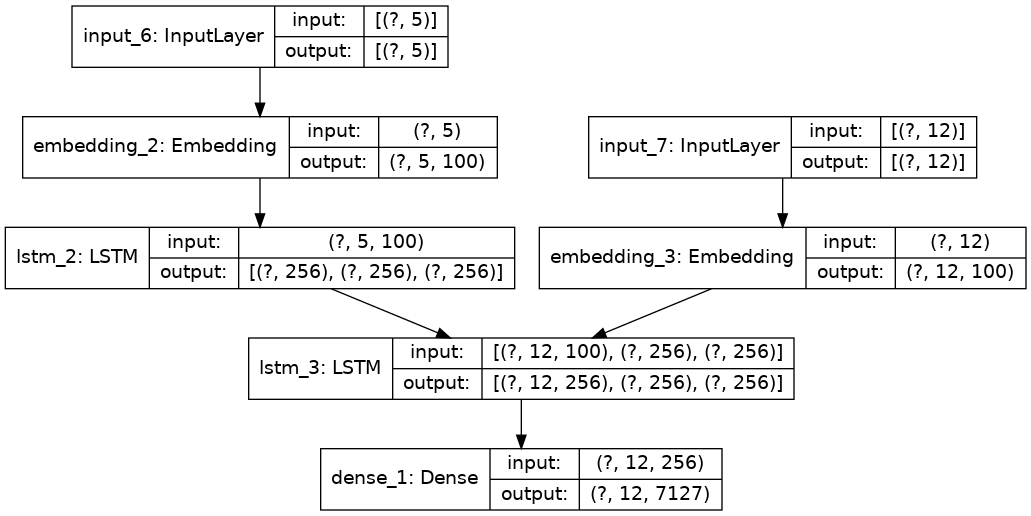

In [47]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='plot/model.png', show_shapes=True, show_layer_names=True)

## Model Training

In [23]:
print(encoder_input_sequences.shape)
print(decoder_input_sequences.shape)
print(decoder_output_sequences.shape)

(20000, 6)
(20000, 12)
(20000, 12)


In [49]:
EPOCHS = 10
BATCH_SIZE = 64
VALIDATION_SPLIT = 0.1

### Data Generator

In [50]:
from tensorflow.keras.utils import Sequence, to_categorical
from sklearn.model_selection import train_test_split

In [51]:
class DataGenerator(Sequence):
    def __init__(self, encoder_input, decoder_input, decoder_output, n_classes, batch_size=32, shuffle=True):
        self.encoder_input = encoder_input
        self.decoder_input = decoder_input
        self.decoder_output = decoder_output
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    # Number of batches per epoch
    def __len__(self):
        return int(np.floor(len(self.encoder_input) / self.batch_size))

    # Generate one batch
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        X = [self.encoder_input[indexes], self.decoder_input[indexes]]
        # Decoder outputs have to be one-hot-encoded
        y = np.asarray([to_categorical(self.decoder_output[index], num_classes=self.n_classes) for index in indexes])
        return X, y

    # Update indexes for next epoch
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.encoder_input))
        if self.shuffle:
            np.random.shuffle(self.indexes)

In [52]:
if USE_DATA_GENERATORS:
    indexes = np.arange(len(encoder_input_sequences))
    np.random.shuffle(indexes)

    validation_size = int(np.floor(len(encoder_input_sequences) * VALIDATION_SPLIT))

    train_indexes = indexes[:-validation_size]
    validation_indexes = indexes[-validation_size:]

    training_generator = DataGenerator(
        encoder_input_sequences[train_indexes],
        decoder_input_sequences[train_indexes],
        decoder_output_sequences[train_indexes],
        n_decoder_tokens,
        BATCH_SIZE
    )

    validation_generator = DataGenerator(
        encoder_input_sequences[validation_indexes],
        decoder_input_sequences[validation_indexes],
        decoder_output_sequences[validation_indexes],
        n_decoder_tokens,
        BATCH_SIZE
    )

In [33]:
if not USE_DATA_GENERATORS:
    # Decoder outputs need to be one-hot-encoded for the dense softmax layer to work
    decoder_output = np.array([to_categorical(output, num_classes=n_decoder_tokens) for output in decoder_output_sequences])

### Training

In [69]:
import matplotlib.pyplot as plt

In [68]:
def plot_history(history):
    plt.plot(history.epoch, history.history['accuracy'])
    plt.plot(history.epoch, history.history['val_accuracy'])
    plt.legend(['Training accuracy', 'Validation accuracy'])

In [53]:
model_name = f'model/translator_{NUM_LINES}_{EPOCHS}_{BATCH_SIZE}_{time.strftime("%Y%m%d_%H%M%S")}'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model/checkpoint',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

if USE_DATA_GENERATORS:
    history = model.fit(
        training_generator,
        validation_data=validation_generator,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint_callback]
    )
else:
    history = model.fit(
        [encoder_input_sequences, decoder_input_sequences],
        decoder_output,
        validation_split=VALIDATION_SPLIT,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[checkpoint_callback]
    )

# Save trained model, compilation and training data and history plot
model.save(model_name)
with open(f'{model_name}/training.txt', 'w') as f:
    f.write(f'LINES:\t {NUM_LINES}\n')
    f.write(f'OPTIMIZER:\t {OPTIMIZER}\n')
    f.write(f'LOSS:\t {LOSS}\n')
    f.write(f'EPOCHS:\t {EPOCHS}\n')
    f.write(f'BATCH:\t {BATCH_SIZE}\n')
    f.write(f'VALIDATION:\t {VALIDATION_SPLIT}\n')
plot_history(history)
plt.savefig(f'{model_name}/history.png')

Epoch 1/10
281/281 [==============================] - ETA: 0s - loss: 2.0477 - accuracy: 0.7126
Epoch 00001: saving model to model/checkpoint
281/281 [==============================] - 126s 449ms/step - loss: 2.0477 - accuracy: 0.7126 - val_loss: 1.6787 - val_accuracy: 0.7547
Epoch 2/10
281/281 [==============================] - ETA: 0s - loss: 1.5029 - accuracy: 0.7723
Epoch 00002: saving model to model/checkpoint
281/281 [==============================] - 139s 494ms/step - loss: 1.5029 - accuracy: 0.7723 - val_loss: 1.4273 - val_accuracy: 0.7886
Epoch 3/10
281/281 [==============================] - ETA: 0s - loss: 1.3057 - accuracy: 0.7987
Epoch 00003: saving model to model/checkpoint
281/281 [==============================] - 145s 517ms/step - loss: 1.3057 - accuracy: 0.7987 - val_loss: 1.3018 - val_accuracy: 0.8048
Epoch 4/10
281/281 [==============================] - ETA: 0s - loss: 1.1817 - accuracy: 0.8138
Epoch 00004: saving model to model/checkpoint
281/281 [==================

NameError: name 'plot_history' is not defined

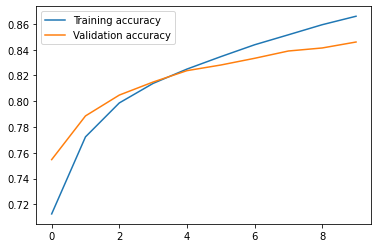

In [71]:
plot_history(history)

### Save / Load

In [ ]:
# model.save_weights('model/translator_weights')

In [ ]:
# model.save('model/translator')

In [ ]:
# model.load_weights('model/translator_weights')

In [73]:
# model = keras.models.load_model('model/translator_30000_10_64_20210405_181843')

## Inference

### Build the model

To predict outputs a separate model is needed because the previous decoder output has to be passed in as an input for the next word

In [74]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_h = Input(shape=(LSTM_DIM,))
decoder_state_c = Input(shape=(LSTM_DIM,))
decoder_states = [decoder_state_h, decoder_state_c]

decoder_input_word = Input(shape=(1,))

inference_decoder = decoder_embedding(decoder_input_word)
inference_decoder, state_h, state_c = decoder_lstm(inference_decoder, initial_state=decoder_states)
inference_decoder = decoder_dense(inference_decoder)

inference_states = [state_h, state_c]

decoder_model = Model(
    [decoder_input_word] + decoder_states,
    [inference_decoder] + inference_states
)

In [25]:
encoder_model.summary()
decoder_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 5, 100)            345300    
_________________________________________________________________
lstm (LSTM)                  [(None, 256), (None, 256) 365568    
Total params: 710,868
Trainable params: 710,868
Non-trainable params: 0
_________________________________________________________________
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 1)]          0                                            
___________________________________________________________

In [ ]:
plot_model(decoder_model, to_file='plot/inference_model.png', show_shapes=True, show_layer_names=True)

### Greedy Search

In [75]:
reverse_source_dict = { v:k for k,v in source_dict.items() }
reverse_target_dict = { v:k for k,v in target_dict.items() }

In [76]:
def sentence_to_sequence(sentence):
    sequence = source_tokenizer.texts_to_sequences([sentence])
    sequence.reverse()
    sequence = pad_sequences([sequence], maxlen=max_source_len, padding='pre')
    return sequence

In [77]:
def sequence_to_sentence(sequence):
    SOS_ID = target_dict[SOS_TOKEN]
    EOS_ID = target_dict[EOS_TOKEN]
    words = []
    for i in sequence:
        if i == SOS_ID:
            continue
        elif i == EOS_ID:
            break
        elif i > 0:
            words.append(reverse_target_dict[i])
        else:
            words.append(UNK_TOKEN)
    return ' '.join(words)

In [78]:
def predict_sequence(source_sequence):
    # Predict the encoder result directly
    current_state = encoder_model.predict(source_sequence)
    
    # Predict ouput words one at a time until <eos> token or max_target_len
    EOS_ID = target_dict[EOS_TOKEN]
    
    # Decoder_model expects a tensor as input
    decoder_input = np.zeros((1, 1))
    decoder_input[0, 0] = target_dict[SOS_TOKEN]
    target_sequence = []
    
    for _ in range(max_target_len):
        dense_outputs, state_h, state_c = decoder_model.predict([decoder_input] + current_state)
        token = np.argmax(dense_outputs[0, 0, :])
        if token == EOS_ID:
            break
        else:
            target_sequence.append(token)
        
        # Replace decoder inputs to last generated token and states
        decoder_input[0, 0] = token
        current_state = [state_h, state_c]
    return target_sequence

def predict(source_sequence):
    target_sequence = predict_sequence(source_sequence)
    return sequence_to_sentence(target_sequence)

### Beam Search

The beam search algorithm is used as an improvement to the greedy search algorithm for determining the next word in the sequence. It works by taking the k best options at each step and then using those for all next steps. The best options are evalueted by maximizing the average log probability of each word is the output. For k=1 this is equivalent to the greedy algorithm. Increasing the k value gives better results but also increases processing time exponentially.

In [79]:
def beam_search_predict_sequence(source_sequence, k=1):
    encoder_output_state = encoder_model.predict([source_sequence])
    decoder_input = np.zeros((1, 1))
    
    # (log(1), initial_sos_token, current_state)
    k_beam = [(0, [target_dict[SOS_TOKEN]], encoder_output_state)]

    EOS_ID = target_dict[EOS_TOKEN]
    for i in range(max_target_len):
        all_k_beams = []
        for prob, predictions, state in k_beam:
            if predictions[-1] == EOS_ID:
                all_k_beams.append((prob, predictions, state))
                continue
            
            decoder_input[0,0] = predictions[-1]
            dense_outputs, state_h, state_c = decoder_model.predict([decoder_input] + state)
            
            # Get indices of top k predictions (last k when sorted)
            top_k = dense_outputs[0,0].argsort()[-k:]

            # Add to all possible candidates for k-beams
            all_k_beams += [
                (
                    # We subtract the log because it's negative
                    # Same as adding but sorting in reverse
                    prob - np.log(dense_outputs[0,0,next_word]),
                    # Append next word to the copy of existing list
                    list(predictions)+[next_word],
                    # Set state to new decoder state
                    [state_h, state_c]
                )
                for next_word in top_k
            ]

        # Get k best tuples sorted by score/length
        k_beam = sorted(all_k_beams, key = lambda t: t[0]/len(t[1]))[:k]

    # Return best sequence
    return k_beam[0][1]

def beam_search_predict(source_sequence, k=1):
    target_sequence = beam_search_predict_sequence(source_sequence, k)
    return sequence_to_sentence(target_sequence)

### Testing

In [89]:
indexes = np.random.randint(0, len(source_sentences), 10)

sample_input_sequences = np.asarray(encoder_input_sequences[indexes])

for i, index in enumerate(indexes):
    print("source:\t" + source_sentences[index])
    print("target:\t" + target_sentences_output[index][:-6])
    print("greedy:\t" + predict(np.asarray([sample_input_sequences[i]])))
    print("beam:\t" + beam_search_predict(np.asarray([sample_input_sequences[i]]), k=3))
    print()

source:	We run together.
target:	Nous courons ensemble.
greedy:	nous avons vite
beam:	nous avons vite

source:	Tom likes that.
target:	Tom aime cela.
greedy:	tom aime ça
beam:	tom aime ça

source:	See you tomorrow.
target:	Nous nous verrons demain.
greedy:	à nous demain
beam:	à nous demain

source:	Give them to him.
target:	Donne-les-lui.
greedy:	donne le lui
beam:	donne le lui

source:	Forget it!
target:	Oubliez-le !
greedy:	oublie
beam:	oubliez ça

source:	I need more gold.
target:	J'ai besoin de plus d'or.
greedy:	j'ai besoin de plus plus
beam:	j'ai besoin de plus plus

source:	I'll warn Tom.
target:	Je préviendrai Tom.
greedy:	je tom tom
beam:	je tom tom

source:	Let's vote.
target:	Passons au vote.
greedy:	allons nous
beam:	faisons

source:	I keep a journal.
target:	Je tiens un journal.
greedy:	je vois un ami
beam:	je vois un ami

source:	I saw you.
target:	Je vous vis.
greedy:	je vous ai vu
beam:	je vous ai vu



## Analysis

### Ground truth comparison

In [ ]:
def to_sequence(sentence):
    sequences = source_tokenizer.texts_to_sequences([sentence])
    sequences[0].reverse()
    sequences = pad_sequences(sequences, maxlen=max_source_len, padding='pre')
#     print(sequences)
    return sequences

In [ ]:
print(predict(to_sequence("what time is it?")))
print(beam_search_predict(to_sequence("what time is it?"), k=3))

### 2D Encoder hidden state PCA

In [ ]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# TODO Predict state for some sentences
i = 0
n = 5

# Sample_sentences = [ ]
sample_sentences = source_sentences[i:i+n+1]

# TODO make make_sequence function
source_sequences = source_tokenizer.texts_to_sequences(sample_sentences)
# Reverse source sequnces
for sequence in source_sequences:
    sequence.reverse()
sample_sequences = pad_sequences(source_sequences, maxlen=max_source_len, padding='pre')

sample_inputs = encoder_model.predict(sample_sequences)[0]

# print(sample_sentences)
# print(sample_inputs)

pca = PCA(n_components=2)
pca.fit(sample_inputs)
pca_inputs = pca.transform(sample_inputs)

plt.scatter(pca_inputs[:,0], pca_inputs[:,1])
for i in range(len(sample_sentences)):
    plt.text(pca_inputs[i,0], pca_inputs[i, 1], sample_sentences[i])

### BLEU score

BLEU (Bilingual Evaluation Understudy) is a score for comparing machine-translated text to one or more reference translations made by a human. Scoring usuall works on indiviual sentences and is then averaged on the entire text. Scores have a value between 0 and 1.

For more info:
- https://en.wikipedia.org/wiki/BLEU
- https://machinelearningmastery.com/calculate-bleu-score-for-text-python/
- https://towardsdatascience.com/bleu-bilingual-evaluation-understudy-2b4eab9bcfd1

In [25]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [ ]:
indexes = np.random.randint(0, len(source_sentences), 10)

sample_input_sequences = np.asarray(encoder_input_sequences[indexes])
sample_output_sequences = []
sample_predictions = []
sample_predictions_beam = []

for index in indexes:
    target_sequence = target_sentences_output[index].split(' ')[:-1]
    prediction_sequence = predict_sequence(np.asarray([sample_input_sequences[i]]))
    prediction_sequence_beam = beam_search_predict_sequence(np.asarray([sample_input_sequences[i]]), k=3)
    
    sample_output_sequences.append([target_sequence])
    sample_predictions.append(prediction_sequence)
    sample_predictions_beam.append(prediction_sequence_beam)
    
    print(f"source:\t {source_sentences[index]}")
    print(f"target:\t {target_sequence}")
    print(f"prediction:\t {prediction_sequence}")
    print(f"beam:\t {prediction_sequence_beam}")
    print(f"score:\t {sentence_bleu([target], prediction_sequence)}")
    print(f"score:\t {sentence_bleu([target], prediction_sequence_beam)}")

print(f"regular corpus score:\t {corpus_bleu(sample_output_sequences, sample_predictions)}")
print(f"beam corpus score:\t {corpus_bleu(sample_output_sequences, sample_predictions_beam)}")

# References

- https://arxiv.org/abs/1409.3215
- https://arxiv.org/abs/1406.1078
- https://arxiv.org/abs/1609.08144
- https://keras.io/examples/nlp/lstm_seq2seq/
- https://nlp.stanford.edu/projects/glove/